# 설정
- 모듈 임포트
- 그림을 출력할 수 있는 함수 준비(MNIST)
- 파이썬 버전 확인
- 사이킷런 버전 확인

In [8]:
# 파이썬 >= 3.5 필수 
import sys
assert sys.version_info >= (3,5)
# sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
# 확인해보니 major 3, minor 8, micro 12 -> python 3.8.12

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# '1.0.1'

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [15]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [16]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [22]:
y.shape

(70000,)

그림 저장: some_digit_plot


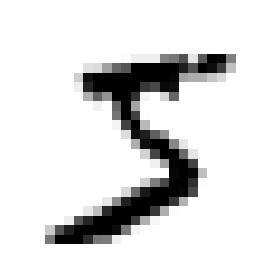

In [25]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

save_fig("some_digit_plot")
plt.show()

In [27]:
y[0]

'5'

In [29]:
y = y.astype(np.uint8)

In [30]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary,
              interpolation="nearest")
    plt.axis('off')

In [70]:
image.shape

(56, 280)

In [38]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    # 이미지 가로 세로 사이즈
    size = 28
    # 한 줄에 이미지 몇 개 ? (10개 이하면 그 수만큼, 이상이면 10개로 고정)
    images_per_row = min(len(instances), images_per_row)
    # instances에서 이미지 size대로 reshape해서 images 리스트에 저장
    images = [instance.reshape(size,size) for instance in instances]
    # 필요한 행의 총 개수 지정
    n_rows = len(instances - 1) // images_per_row + 1
    # 한 행에 들어갈 이미지 빈 리스트 생성
    row_images = []
    # 비어있는 칸에 들어갈 흰색 이미지의 개수 생성
    n_empty = n_rows * images_per_row - len(instances)
    # 흰색 이미지를 만들어서 images 리스트에 추가
    images.append(np.zeros((size,size * n_empty)))
    # 한 행씩 돌면서
    for row in range(n_rows):
        # 한 행에 들어갈 이미지의 범위를 지정
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        # 한 행에 들어갈 이미지 array를 모두 axis = 1로 통합하고 row_images에 추가
        row_images.append(np.concatenate(rimages, axis=1))
    # row_image를 axis=0으로 통합하여 image라는 변수 array로 만듬
    image = np.concatenate(row_images, axis=0)
    # array 상태인 image를 그림으로 표현함 cmap = binary로
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    # 축은 없앰
    plt.axis('off')

그림 저장: more_digits_plot


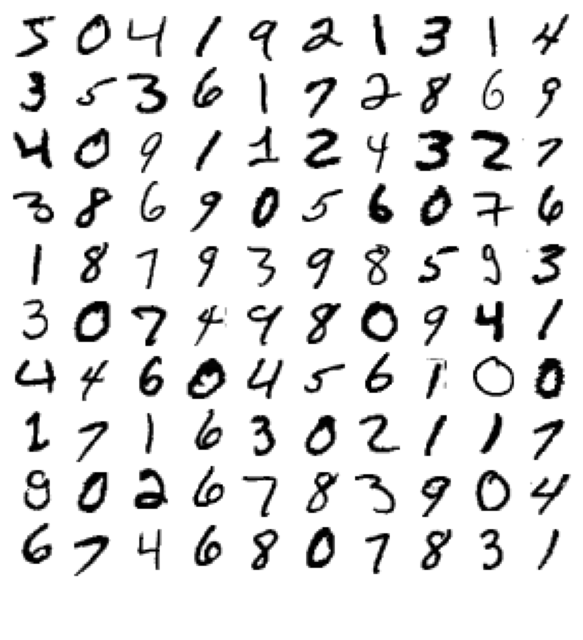

In [42]:
# 칸 만듬 (개별 칸 사이즈 (9,9))
plt.figure(figsize=(9,9))
# example_images를 100개 뽑음
example_images = X[:100]
# 위에서 정의한 plot_digits 사용 
plot_digits(example_images, images_per_row=10)
# save_fig로 이미지 저장
save_fig('more_digits_plot')
# plt.show()
plt.show()

In [74]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기

In [75]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

<b>노트</b>:```max_iter```와 ```tol``` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않겠습니다.

In [76]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [77]:
sgd_clf.predict([some_digit])

array([ True])

In [79]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [85]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# skfolds.split()은 계층별로 나눈 것의 train_index와 test_index를 반환
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # sgd_clf model 복사
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.8642
0.87215
0.88795


In [86]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [87]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

노트 : 이 출력이 책의 내용과 조금 다를 수 있습니다. 걱정할 필요 없습니다. 괜찮습니다! 달라지는 이유가 몇가지 있습니다:
- 첫째, 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 결괏값이 바뀔 수 있습니다. 최신 사이킷런 버전을 사용한다면(일반적으로 권장됩니다) 책이나 이 노트북을 만들 때 사용한 버전과 다를 것이므로 차이가 납니다. 노트북은 최신으로 업데이트하려고 노력하지만 책의 내용은 그렇게 할 수 없습니다.
- 둘째, 많은 훈련 알고리즘은 확률적입니다. 즉 무작위성에 의존합니다. 이론적으로 의사 난수를 생성하도록 난수 생성기에 시드 값을 지정하여 일관된 결과를 얻을 수 있습니다(random_state=42 나 np.random.seed(42)를 종종보게되는 이유입니다.) 하지만 여기에서 언급한 다른 요인으로 인해 충분하지 않을 때가 있습니다.
- 셋째, 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 실행되면 연산이 실행되는 정확한 순서가 보장되지 않습니다. 따라서 결과값이 조금 다를 수 있습니다.
- 마지막으로, 여러 세션에 걸쳐 순서가 보장되지 않는 파이썬 딕셔너리(dict)이나 셋(set)같은 것은 완벽한 재현성이 불가능합니다. 또한 디렉토리 안에 있는 파일의 순서도 보장되지 않습니다. 



In [102]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [103]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [104]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)